In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


# Configure the hyperparameters

In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 256  # We'll resize input images to this size
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 128
num_heads = 4
transformer_units = [
                     projection_dim * 2,
                     projection_dim,
                    ]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier
input_shape = (384, 384, 3)

In [4]:
num_patches

1024

In [5]:
data_augmentation = keras.Sequential(
                                     [
                                        layers.experimental.preprocessing.Normalization(),
                                        layers.experimental.preprocessing.Resizing(image_size, image_size,interpolation='bilinear'),
                                        layers.experimental.preprocessing.RandomFlip('horizontal'),
                                     ],
                                     name = 'data_augmentation',
                                    )
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

# Implement Multi Layer Perceptron (MLP)

In [6]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Implement Patch creation as a layer

In [20]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])

        return patches


(1, 256, 256, 3)
Image size: 256 X 256
Patch size: 8 X 8
Number of Patches per image: 1024
Number of Elements per patch: 192


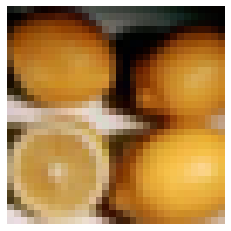

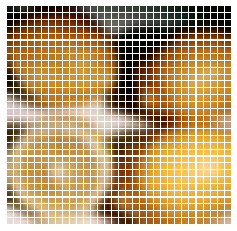

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
print(resized_image.shape)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Number of Patches per image: {patches.shape[1]}")
print(f"Number of Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")


# Implement Patch encoding layer

The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

In [22]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding( input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


# Build  Transfomer Layer 

In [23]:
class TransfomerLayer(layers.Layer):
    
    def __init__(self, transformer_layers, projection_dim, num_heads, transformer_units, dropout=0.1, epsilon=1e-6 ):
        super(TransfomerLayer, self).__init__()
        self.transformer_layers = transformer_layers
        self.projection_dim = projection_dim
        self.num_heads = num_heads
        self.transformer_units = transformer_units
        self.dropout = dropout
        self.epsilon=epsilon
        
    def call (self, encoded_patches):

        # Create multiple layers of the Transformer block.
        for _ in range(self.transformer_layers):
            # Layer normalization 1.
            x1 = layers.LayerNormalization(epsilon= self.epsilon)(encoded_patches)
            # Create a multi-head attention layer.
            attention_output = layers.MultiHeadAttention(
                                      num_heads=self.num_heads, key_dim=self.projection_dim, dropout=self.dropout
                                                        )(x1, x1)
            # Skip connection 1.
            x2 = layers.Add()([attention_output, encoded_patches])
            # Layer normalization 2.
            x3 = layers.LayerNormalization(epsilon=self.epsilon)(x2)
            # MLP.
            x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=self.dropout)
            # Skip connection 2.
            encoded_patches = layers.Add()([x3, x2])

        representation = layers.LayerNormalization(epsilon=self.epsilon)(encoded_patches)
        return representation


In [11]:
a = tf.random.normal((1,384,384,3))

In [24]:
inputs = layers.Input(shape=input_shape)
# Augment data.
augmented = data_augmentation(inputs)
print(augmented.shape)

# Create patches.
patches = Patches(patch_size)(augmented)
print(patches.shape)
# Encode patches.
encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
print(encoded_patches.shape)
encoder = TransfomerLayer(transformer_layers, projection_dim, num_heads, transformer_units)(encoded_patches)

(None, 256, 256, 3)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(None, None, 192)
(None, 1024, 128)


In [18]:
encoder

<KerasTensor: shape=(None, 1024, 128) dtype=float32 (created by layer 'transfomer_layer_4')>

In [ ]:
    # Create a [batch_size, projection_dim] tensor.
    #representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)